In [23]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

# KNN

In [2]:
df = np.load('data.npy',allow_pickle=True)
df = pd.DataFrame(df,columns=['game_id','ebd_ResNet','ebd_VIT','Label','TimeStamps'])

labels = np.array(df.iloc[:,3])

labels,frequency = np.unique(labels,return_counts = True)


In [3]:
df.iloc[:,1] = df.iloc[:,1].map(lambda cell: np.array(cell).flatten(),na_action='ignore')
df.iloc[:,2] = df.iloc[:,2].map(lambda cell: np.array(cell).flatten(),na_action='ignore')

## Task 1 - Distribution of the labels

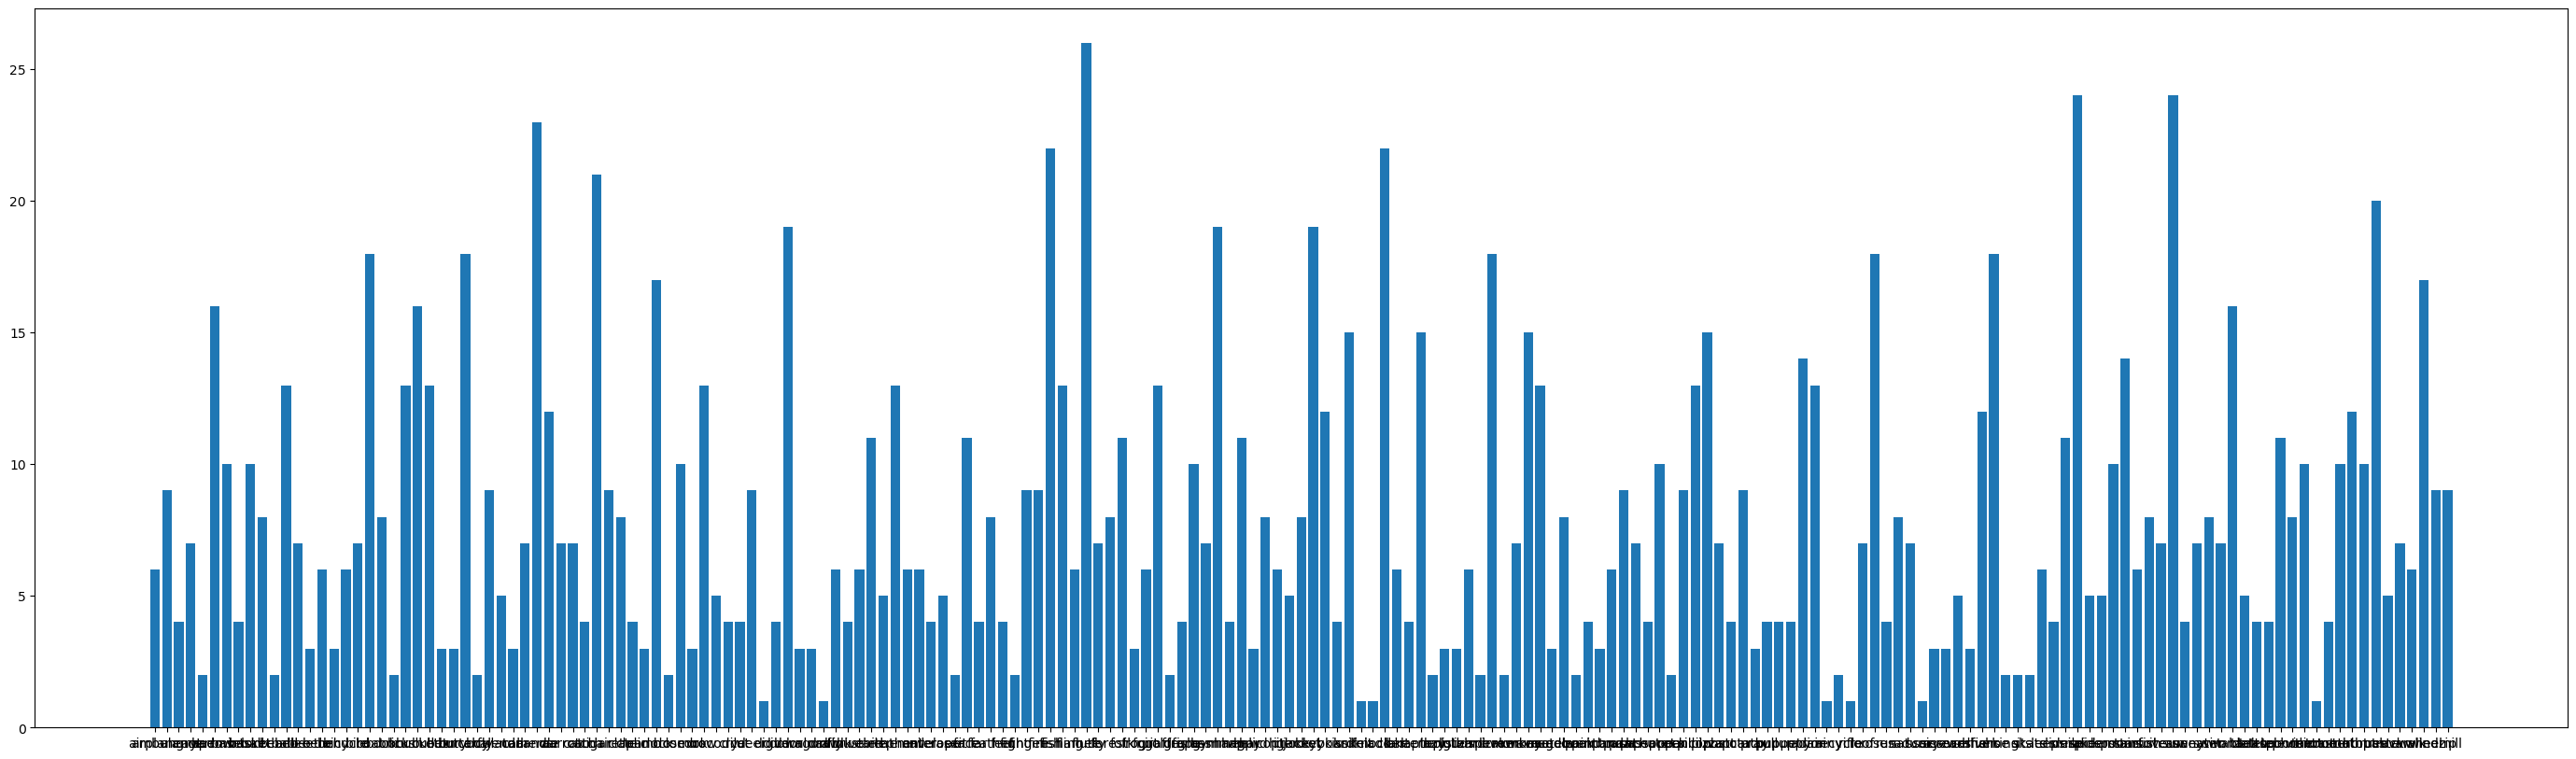

In [4]:
plt.figure(figsize=(35,10))
plt.bar(labels,frequency)
# plt.xticks(rotation=45)
plt.show()

## Distance Metric Implemented

In [5]:
import enum
from numpy.linalg import norm

def cosine(test_point,train_set):
    cosine_lambda = lambda train_point: 1-(np.dot(test_point,train_point) / (norm(test_point)*norm(train_point)))
    return np.argsort(np.array(list(map(cosine_lambda,train_set))))

def euclidean(test_point,train_set):
    euclidean_lambda = lambda train_point: norm(test_point-train_point)
    return np.argsort(np.array(list(map(euclidean_lambda,train_set))))

def manhattan(test_point,train_set):
    manhattan_lambda = lambda train_point: np.sum(np.abs(test_point-train_point))
    return np.argsort(np.array(list(map(manhattan_lambda,train_set))))

distance_func = [cosine,euclidean,manhattan]
              

## KNN Class Implemented
 - knn.fit => takes training data and labels and fits into the classifier
 - knn.test => takes testing data and labels and returns Accuracy, precision, Recall and F1 score metrics

In [6]:
import statistics as st
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,multilabel_confusion_matrix
class knn:
    def __init__(self,k,encoder,distance):
        self.hyperparameters={
            'k':k,
            'encoder':encoder,
            'distance':distance
        }
        
    def fit(self,x_train,y_train):
        self.x_train = np.array(x_train)
        self.y_train = np.array(y_train)
    
    def test(self,x_test,y_test):
        test_result = np.vectorize(distance_func[self.hyperparameters['distance']-1],excluded=['train_set'],otypes=[np.ndarray])
        
        y_predicted = np.array(list(map(lambda dist: st.mode(self.y_train[dist][:self.hyperparameters['k']]),np.array(test_result(test_point = x_test,train_set = self.x_train)))))
        
        return (accuracy_score(np.array(y_test),y_predicted),f1_score(y_predicted,np.array(y_test),average='weighted',zero_division=1.0),precision_score(y_predicted,np.array(y_test),average='weighted',zero_division=1.0),recall_score(y_predicted,np.array(y_test),average='weighted',zero_division=1.0))
        
    

## Enum for distances and Encoder Type

In [7]:
class encoders(enum.Enum):
    ResNet = 1
    VIT = 2

class distances(enum.Enum):
    cosine = 1
    euclidean = 2
    manhattan = 3

In [8]:
from sklearn.model_selection import train_test_split
import heapq

## Testing on All combinations of hyperparameters ( k, encoder, distance metric)
### Using Heapsort to sort the Tuples based on their Accuracy Score

In [9]:
heap = []
for k_ in range(1,int(np.sqrt(df.shape[0]))):
    for encoder_ in range(1,3):
        x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,encoder_],df.loc[:,'Label'] , random_state=42,test_size=0.25, shuffle=True)
        for distance_ in range(1,4):
            classifier = knn(k=k_,encoder=encoder_,distance=distance_)
            classifier.fit(x_train,y_train)
#             print(f"({k_},{encoder_},{distance_})",end=" ")
            accuracy,f1,precision,recall = classifier.test(x_test,y_test)
            heapq.heappush(heap,(-accuracy,k_,encoder_,distance_))
            

In [10]:
table = []
heap_copy=heap
for i in range(40):
    acc, *tup = heapq.heappop(heap)
    table.append((-acc,tup[0],encoders(tup[1]).name,distances(tup[2]).name))

### Top 20 Hyperparameter Tuples sorted in descending Order of their Accuracy Score

In [14]:
pd.DataFrame(table[:20],columns=['Accuracy','K','Encoder','Distance Metric'])

,Accuracy,K,Encoder,Distance Metric
0,0.296000,12,VIT,manhattan
1,0.288000,13,VIT,manhattan
2,0.280000,11,VIT,manhattan
3,0.277333,14,VIT,manhattan
4,0.274667,4,VIT,manhattan
5,0.272000,8,VIT,manhattan
6,0.269333,3,VIT,manhattan
7,0.269333,5,VIT,euclidean
8,0.269333,10,VIT,manhattan
9,0.269333,21,VIT,manhattan


In [15]:
accuracy_list = []
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,2],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
classifier = knn(k=1,encoder=2,distance=1)
classifier.fit(x_train,y_train)
for k_ in range(1,int(np.sqrt(df.shape[0]))):
    classifier.hyperparameters['k'] = k_
    accuracy,f1,precision,recall = classifier.test(x_test,y_test)
    accuracy_list.append(accuracy)
    

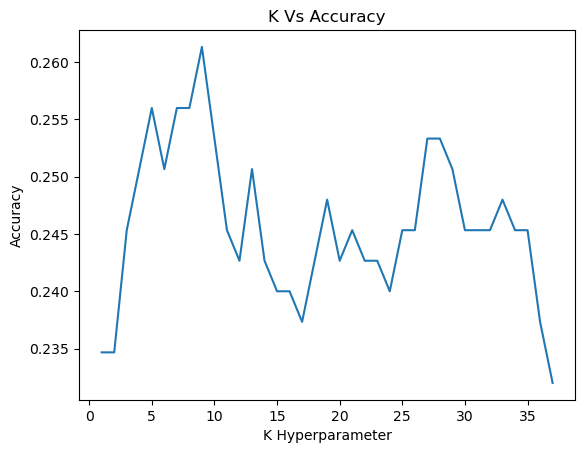

In [16]:
plt.plot(range(1,int(np.sqrt(df.shape[0]))),accuracy_list)
plt.xlabel("K Hyperparameter")
plt.ylabel("Accuracy")
plt.title("K Vs Accuracy")
plt.show()

Note: The model is already optimized so we dont calculate inference for Unoptimized Model

In [17]:
import time
from sklearn.neighbors import KNeighborsClassifier

# inference time for the initial model
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
classifier = knn(k=1,encoder=1,distance=1)
classifier.fit(x_train,y_train)
start = time.time()
accuracy,f1,precision,recall = classifier.test(x_test,y_test)
end = time.time()
inference1 = end - start

# inference time for the best Hypeparameter set model
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,encoders[table[0][2]].value],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
classifier = knn(k=table[0][1],encoder=encoders[table[0][2]].value,distance=distances[table[0][3]].value)
classifier.fit(x_train,y_train)
start = time.time()
accuracy,f1,precision,recall = classifier.test(x_test,y_test)
end = time.time()
inference2 = end - start

# inference time for the Sklearn KNN classifier
sk_classifier = KNeighborsClassifier(n_neighbors = table[0][1], metric = table[0][3])
x_train_list = []
x_test_list = []
x_train = np.array(x_train)
for i in range(len(x_train)):
    x_train_list.append(x_train[i])
# print(x_train_list)
x_test = np.array(x_test)
for i in range(len(x_test)):
    x_test_list.append(x_test[i])

sk_classifier.fit(x_train_list,np.array(y_train))
start = time.time()
sk_classifier.predict(x_test_list)
end = time.time()
inference3 = end - start
print(inference1,inference2, inference3)                                                            

1.5517027378082275 0.9989778995513916 0.08665704727172852


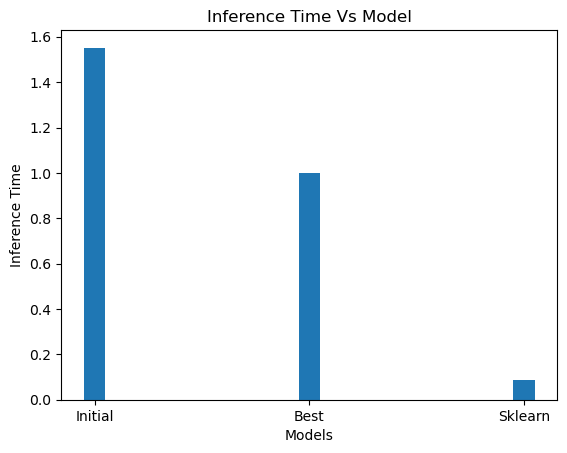

In [18]:
x_ = ['Initial','Best', 'Sklearn']
y_ = [inference1,inference2,inference3]

plt.bar(x_,y_,align = 'center',width=0.1)
plt.xlabel('Models')
plt.ylabel('Inference Time')
plt.title('Inference Time Vs Model')
plt.show()

In [19]:
from numpy import random

In [20]:
train_size = [0.1, 0.2, 0.4, 0.5,0.6,0.8,0.9,1]

# Inference for initial Model with varying train data Size
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,1],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
classifier = knn(k=1,encoder=1,distance=1)
inference1_list = []
for size in train_size:
    classifier.fit(random.permutation(x_train)[:int(size*len(x_train))],y_train)
    start = time.time()
    accuracy,f1,precision,recall = classifier.test(x_test,y_test)
    end = time.time()
    inference1 = end - start
    inference1_list.append(inference1)
    
# Inference for Best Model with varying train data Size
x_train, x_test, y_train, y_test = train_test_split(df.iloc[:,encoders[table[0][2]].value],df.loc[:,'Label'] , random_state=104,test_size=0.25, shuffle=True)
classifier = knn(k=1,encoder=1,distance=1)
inference2_list = []
for size in train_size:
    classifier.fit(random.permutation(x_train)[:int(size*len(x_train))],y_train)
    start = time.time()
    accuracy,f1,precision,recall = classifier.test(x_test,y_test)
    end = time.time()
    inference2 = end - start
    inference2_list.append(inference2)
    
# Inference for Sklearn Model with varying train data Size
sk_classifier = KNeighborsClassifier(n_neighbors = table[0][1], metric = table[0][3])
x_train_list = []
x_test_list = []
x_train = np.array(x_train)
for i in range(len(x_train)):
    x_train_list.append(x_train[i])
# print(x_train_list)
x_test = np.array(x_test)
for i in range(len(x_test)):
    x_test_list.append(x_test[i])

inference3_list = []
for size in train_size:
    sk_classifier.fit(x_train_list[:int(size*len(x_train_list))],np.array(y_train)[:int(size*len(x_train_list))])
    start = time.time()
    sk_classifier.predict(x_test_list)
    end = time.time()
    inference3_list.append(end - start)


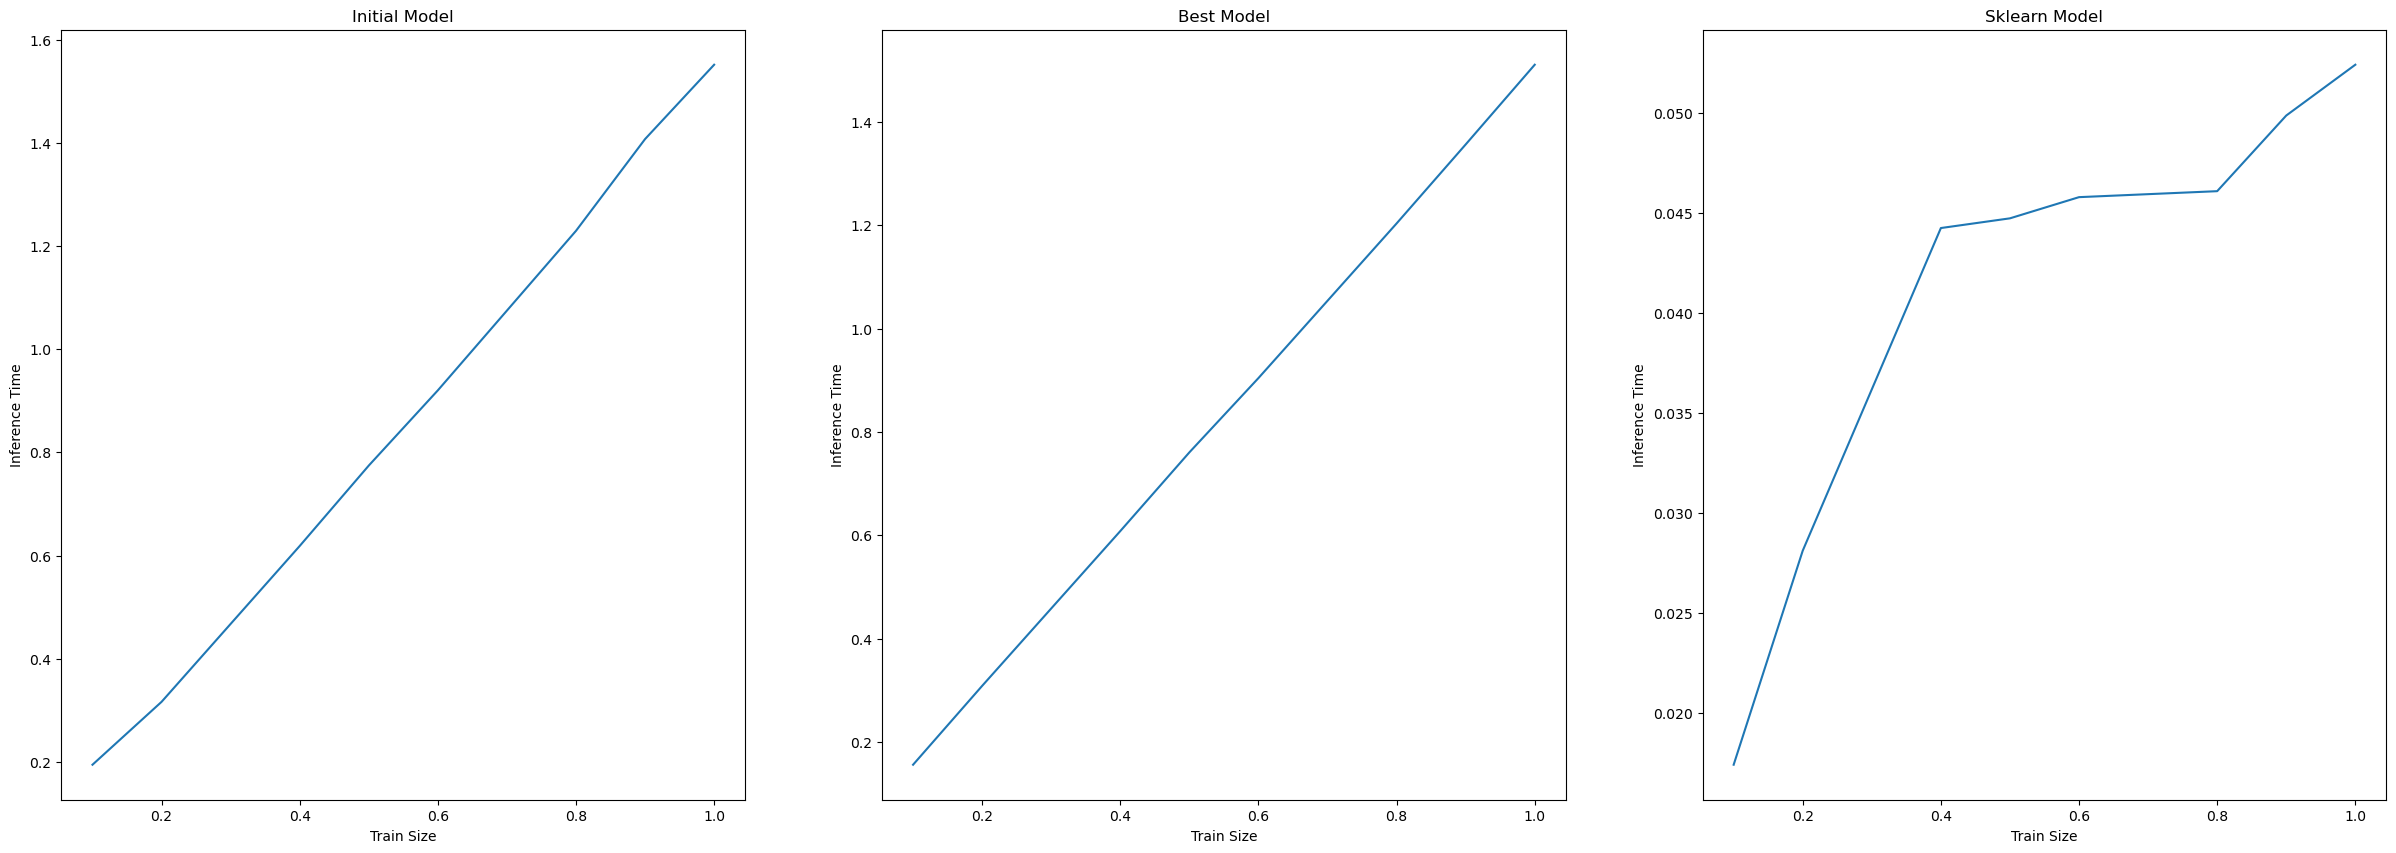

In [21]:
fig,axs = plt.subplots(1,3, figsize = (30,10))
axs[0].plot(train_size, inference1_list)
axs[0].set_xlabel('Train Size')
axs[0].set_ylabel('Inference Time')
axs[0].set_title('Initial Model')
axs[1].plot(train_size, inference2_list)
axs[1].set_xlabel('Train Size')
axs[1].set_ylabel('Inference Time')
axs[1].set_title('Best Model')
axs[2].plot(train_size, inference3_list)
axs[2].set_xlabel('Train Size')
axs[2].set_ylabel('Inference Time')
axs[2].set_title('Sklearn Model')
plt.show()

# Decision Tree

## Data visualization

[]

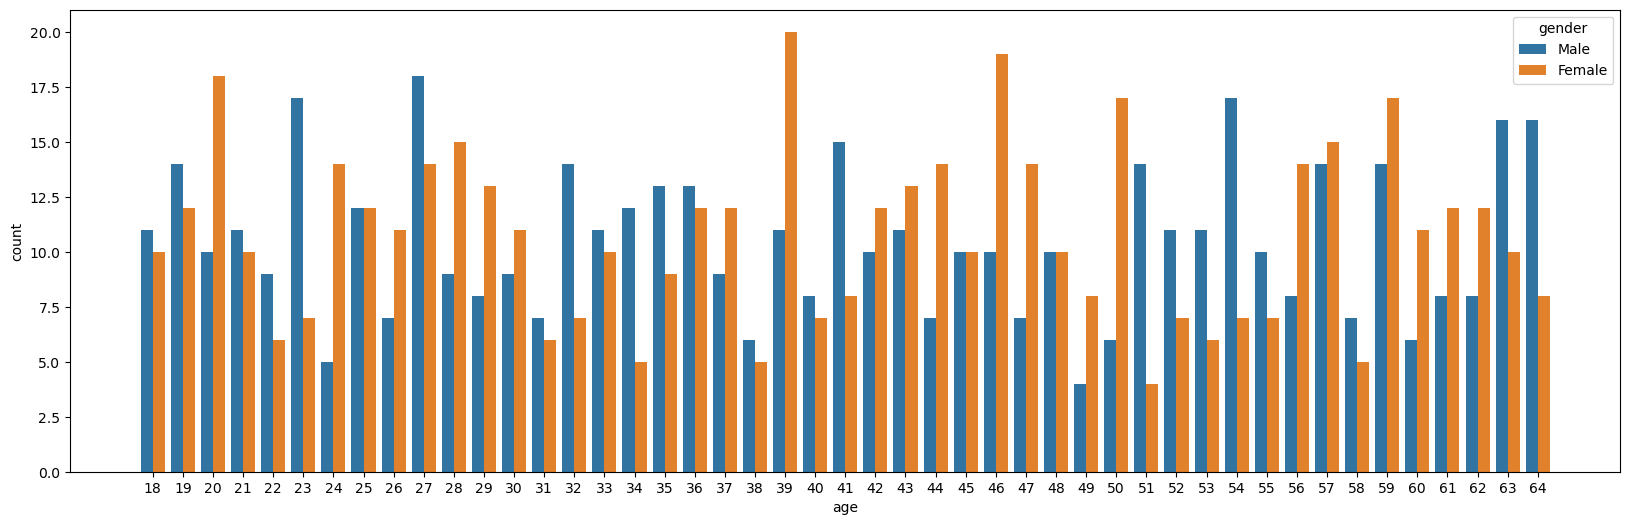

In [24]:
df = pd.read_csv('advertisement.csv')
plt.figure(figsize=(20,6))
g = sns.countplot(data=df,x="age",hue="gender")
plt.plot()

/opt/homebrew/Caskroom/miniforge/base/envs/myenv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


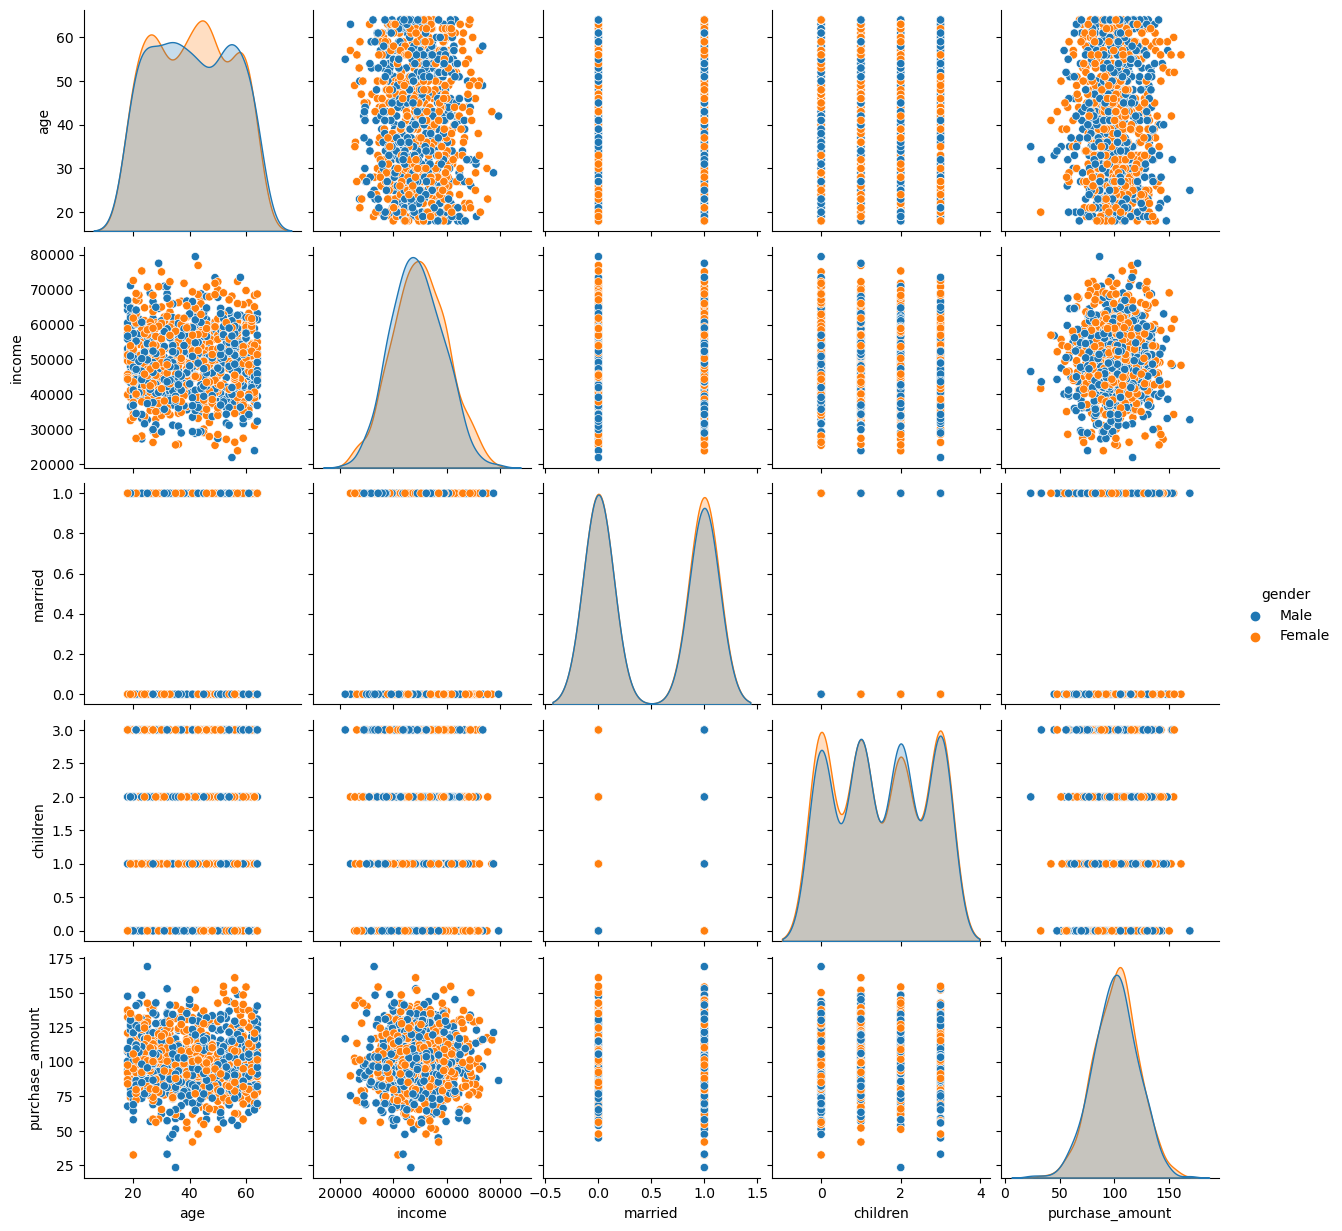

In [25]:
sns.pairplot(df, hue = 'gender')

In [26]:
import enum
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score,multilabel_confusion_matrix

class criterions(enum.Enum):
    gini = 1
    entropy = 2

max_depth = [3,5,10,20,30]
max_features = [3,5,7,9,11]

class DecTree:
    def __init__(self,criterion,mx_depth,mx_features):
        self.hyperparameters={
            'criterion': criterion,
            'mx_depth': mx_depth,
            'mx_features': mx_features
        }
        self.clf = DecisionTreeClassifier(criterion = criterions(self.hyperparameters['criterion']).name,max_depth=self.hyperparameters['mx_depth'],max_features = self.hyperparameters['mx_features'])
        
    def fit(self,x_train,y_train):
        self.clf.fit(x_train, y_train)
    
    def test(self,x_test,y_test):
        y_predicted = self.clf.predict(x_test)
        return (multilabel_confusion_matrix(y_test,y_predicted),accuracy_score(y_test,y_predicted),f1_score(y_test,y_predicted,average='micro'),precision_score(y_test,y_predicted,average='micro'),recall_score(y_test,y_predicted,average='micro'))
        

## Data preprocessing

In [27]:
s = {1}
s.remove(1)
def appendLabels(labels):
    s.update(labels.split(' '))
        
unique_labels = np.vectorize(appendLabels)
unique_labels(df.loc[:,'labels'])
s = np.sort(list(s))


## Powerset Formulation

In [28]:
from itertools import chain, combinations

powerset = list(chain.from_iterable(combinations(s, r) for r in range(len(s)+1)))

### Data featurization

In [29]:
def update_labels(labels):
    x = labels.split(' ')
    x.sort()
    return powerset.index(tuple(x))

In [30]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
df['labels'] = encoder.fit_transform(pd.Series(np.vectorize(update_labels)(df['labels'])))

In [31]:
encoded_df = pd.concat([df.loc[:,['age','income','children','married','purchase_amount']],pd.get_dummies(df.loc[:,['gender','education','occupation','most bought item']])],axis=1)

### Train Test Split

In [32]:
x_train, x_test, y_train, y_test = train_test_split(encoded_df,df['labels'], random_state=42,test_size=0.25, shuffle=True)

In [33]:
import heapq
heap = []
for depth in max_depth:
    for features in max_features:
        classifier = DecTree(mx_depth = depth,mx_features = features,criterion = 1)
        classifier.fit(np.array(x_train),y_train)
        con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
        heapq.heappush(heap,(-f1,depth,features,1))
        classifier = DecTree(mx_depth = depth,mx_features = features,criterion = 2)
        classifier.fit(np.array(x_train),y_train)
        con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
        heapq.heappush(heap,(-f1,depth,features,2))

In [34]:
table = []
heap_copy=heap
for i in range(3):
    f1, *tup = heapq.heappop(heap)
    table.append((-f1,tup[0],tup[1],criterions(tup[2]).name))

In [35]:
pd.DataFrame(table[:20],columns=['f1','Max Depth','Max Features','Criterion'])

,f1,Max Depth,Max Features,Criterion
0,0.068,5,11,gini
1,0.056,5,3,gini
2,0.056,20,5,gini


In [36]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
classifier = DecTree(mx_depth = table[0][1],mx_features = table[0][2],criterion = criterions[table[0][3]].value)
average_acc,average_f1,average_prec,average_recall = 0,0,0,0
for train_idx, test_idx in kf.split(encoded_df):
    x_train, y_train = encoded_df.iloc[train_idx], df['labels'][train_idx]
    x_test, y_test = encoded_df.iloc[test_idx], df['labels'][test_idx]
    classifier.fit(np.array(x_train),y_train)
    con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
    average_acc += acc
    average_f1 += f1
    average_prec += prec
    average_recall += recall
    
print("Average Accuracy =",average_acc/5)
print("Average f1 =",average_f1/5)
print("Average Precision =", average_prec/5)
print("Average Recall =", average_recall/5)

Average Accuracy = 0.044000000000000004
Average f1 = 0.044000000000000004
Average Precision = 0.044000000000000004
Average Recall = 0.044000000000000004


## Multi Output Formulation

In [37]:
df = pd.read_csv('advertisement.csv')

### Data featurization

In [38]:
def present(arr,str):
    return 1 if str in arr else 0
#     if str in arr:
#         return 1
#     else:
#         return 0
for i in s:
    df[i] = df['labels'].apply(lambda arr: present(arr,i))

### Train test split

In [39]:
x_train, x_test, y_train, y_test = train_test_split(encoded_df,df.iloc[:,-8:], random_state=42,test_size=0.25, shuffle=True)

In [40]:
import heapq
heap = []
for depth in max_depth:
    for features in max_features:
        classifier = DecTree(mx_depth = depth,mx_features = features,criterion = 1)
        classifier.fit(np.array(x_train),y_train)
        con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
        heapq.heappush(heap,(-f1,depth,features,1))
        classifier = DecTree(mx_depth = depth,mx_features = features,criterion = 2)
        classifier.fit(np.array(x_train),y_train)
        con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
        heapq.heappush(heap,(-f1,depth,features,2))

In [41]:
table = []
heap_copy=heap
for i in range(3):
    f1, *tup = heapq.heappop(heap)
    table.append((-f1,tup[0],tup[1],criterions(tup[2]).name))

In [42]:
pd.DataFrame(table[:20],columns=['f1','Max Depth','Max Features','Criterion'])

,f1,Max Depth,Max Features,Criterion
0,0.531014,30,7,gini
1,0.514788,20,7,gini
2,0.511940,30,11,entropy


In [43]:
kf = KFold(n_splits=5, shuffle=True, random_state=42) 
classifier = DecTree(mx_depth = table[0][1],mx_features = table[0][2],criterion = criterions[table[0][3]].value)
average_acc,average_f1,average_prec,average_recall = 0,0,0,0
for train_idx, test_idx in kf.split(encoded_df):
    x_train, y_train = encoded_df.iloc[train_idx], df.iloc[train_idx,-8:]
    x_test, y_test = encoded_df.iloc[test_idx], df.iloc[test_idx,-8:]
    classifier.fit(np.array(x_train),y_train)
    con_matrix, acc,f1,prec,recall = classifier.test(np.array(x_test),y_test)
    average_acc += acc
    average_f1 += f1
    average_prec += prec
    average_recall += recall
    
print("Average Accuracy =",average_acc/5)
print("Average f1 =",average_f1/5)
print("Average Precision =", average_prec/5)
print("Average Recall =", average_recall/5)

Average Accuracy = 0.032
Average f1 = 0.5080173210924931
Average Precision = 0.5116562656172048
Average Recall = 0.5050984988295881
